# Standard RB Demo

This is a very basic implemention of a standard RB experiment

In [1]:
import numpy as np
import qiskit_experiments as qe
rb = qe.randomized_benchmarking

# For simulation
from qiskit.test.mock import FakeParis
backend = FakeParis()

## Running 1-qubit RB

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: d1d5fd68-5738-4ece-a8d7-5eeafebab992
Status: COMPLETE
Circuits: 70
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- popt: [0.46238615 0.99415355 0.52084735]
- popt_keys: ['a', 'alpha', 'b']
- popt_err: [0.00683844 0.00027185 0.00683899]
- pcov: [[ 4.67642543e-05  1.24759963e-06 -4.24269785e-05]
 [ 1.24759963e-06  7.39044902e-08 -1.55052804e-06]
 [-4.24269785e-05 -1.55052804e-06  4.67717527e-05]]
- reduced_chisq: 0.4388697070118868
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.0029232259806683536
- EPC_err: 0.0001367262650201599

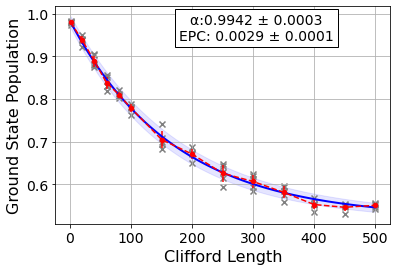

In [2]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 5
seed = 1010

# Run an RB experiment on qubit 0
exp1 = rb.RBExperiment([0], lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
expdata1

## Running 2-qubit RB

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: 6a3e0114-222a-49e0-87ed-fdc6cccf20a2
Status: COMPLETE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- popt: [0.69804979 0.95967529 0.26128011]
- popt_keys: ['a', 'alpha', 'b']
- popt_err: [0.01974724 0.00226682 0.00524554]
- pcov: [[ 3.89953410e-04 -1.53390386e-05 -1.52055454e-05]
 [-1.53390386e-05  5.13845515e-06 -6.04156991e-06]
 [-1.52055454e-05 -6.04156991e-06  2.75156573e-05]]
- reduced_chisq: 0.06491004634085058
- dof: 7
- xrange: [1.0, 200.0]
- EPC: 0.030243532778885363
- EPC_err: 0.0017715492726786291

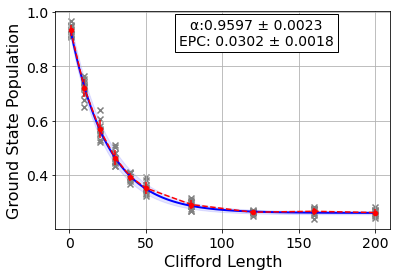

In [3]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an RB experiment on qubits 0,
exp2 = rb.RBExperiment([0, 1], lengths, num_samples=num_samples, seed=seed)
expdata2 = exp2.run(backend)

# View result data
expdata2

## Running parallel RB experiments

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: 9d734cb8-798c-4f82-b8df-a99ce6f3cd6f
Status: COMPLETE
Component Experiments: 5
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['RBExperiment', 'RBExperiment', 'RBExperiment', 'RBExperiment', 'RBExperiment']
- experiment_ids: ['a73682b3-67ed-46b5-a923-b0f1064c983b', '371ded70-6ecd-48a6-b2ec-14ff17dc3296', '0f3121bb-b5f4-4c7e-bfe5-7981b55ffa98', '48fa576b-c5f4-466a-bb45-4e4400a0b13e', '258904b3-0a79-444e-be68-81411f9bdb8e']
- experiment_qubits: [(0,), (1,), (2,), (3,), (4,)]

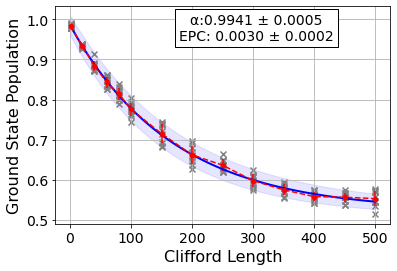

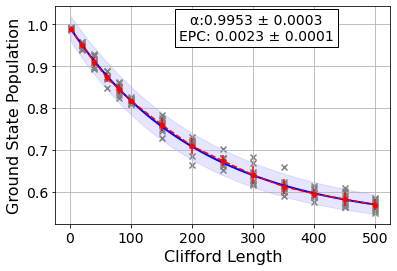

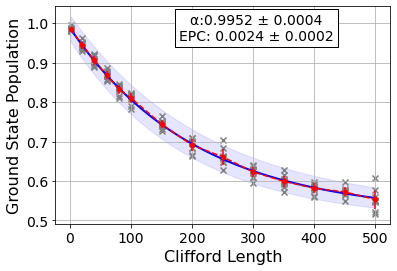

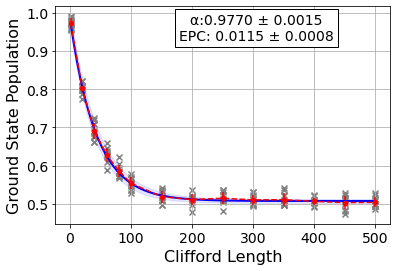

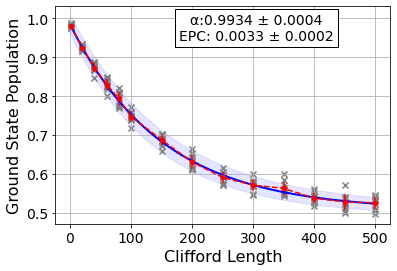

In [4]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed1 = 1010

exps = [rb.RBExperiment([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in range(5)]

par_exp = qe.composite.ParallelExperiment(exps)
par_expdata = par_exp.run(backend)

# View result
par_expdata

#### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`

In [5]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i), '\n')

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: a73682b3-67ed-46b5-a923-b0f1064c983b
Status: COMPLETE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- popt: [0.4643507  0.99406865 0.52152326]
- popt_keys: ['a', 'alpha', 'b']
- popt_err: [0.01182219 0.0004679  0.01284652]
- pcov: [[ 1.39764110e-04  4.23759001e-06 -1.44437570e-04]
 [ 4.23759001e-06  2.18934581e-07 -5.30418292e-06]
 [-1.44437570e-04 -5.30418292e-06  1.65033047e-04]]
- reduced_chisq: 0.12432972252004643
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.0029656752730862213
- EPC_err: 0.00023534816076118423 

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: 371ded70-6ecd-48a6-b2ec-14ff17dc3296
Status: COMPLETE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- popt: [0.46767604 0.99534127 0.52400597]
- popt_keys: ['a', 'alpha', 'b'